In [539]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

users = pd.read_csv("/content/drive/MyDrive/cohort-retention-analysis/data/users.csv")
events = pd.read_csv("/content/drive/MyDrive/cohort-retention-analysis/data/events.csv")

print(users.shape, events.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(20000, 6) (483046, 4)


#Monthly cohorts model for fintech
###cohort_month >> when they joined
###event_month >> when they acted
###cohort_index >> how old the user was or user age in months

In [540]:
import pandas as pd

# Ensure datetime
users["signup_date"] = pd.to_datetime(users["signup_date"])
events["event_ts"] = pd.to_datetime(events["event_ts"])

# Cohort month (signup month)
users["cohort_month"] = users["signup_date"].dt.to_period("M").dt.to_timestamp()

# Event month (activity month)
events["event_month"] = events["event_ts"].dt.to_period("M").dt.to_timestamp()

# Join cohort_month onto events
events = events.merge(users[["user_id", "cohort_month"]], on="user_id", how="left")

# Cohort index = months since signup cohort (0 = signup month)
events["cohort_index"] = (
    (events["event_month"].dt.year - events["cohort_month"].dt.year) * 12
    + (events["event_month"].dt.month - events["cohort_month"].dt.month)
)

print(events[["user_id", "cohort_month", "event_month", "cohort_index"]].head())
print("cohort_index min/max:", events["cohort_index"].min(), events["cohort_index"].max())

  user_id cohort_month event_month  cohort_index
0     U_1   2023-08-01  2023-08-01             0
1     U_1   2023-08-01  2023-08-01             0
2     U_1   2023-08-01  2023-08-01             0
3     U_1   2023-08-01  2023-09-01             1
4     U_1   2023-08-01  2023-10-01             2
cohort_index min/max: 0 12


In [541]:
events.head(20)

,user_id,event_ts,event_name,amount,event_month,cohort_month,cohort_index
0,U_1,2023-08-11 02:00:00,app_open,0.00,2023-08-01,2023-08-01,0
1,U_1,2023-08-11 06:00:00,login,0.00,2023-08-01,2023-08-01,0
2,U_1,2023-08-15 12:00:00,login,0.00,2023-08-01,2023-08-01,0
3,U_1,2023-09-14 08:00:00,app_open,0.00,2023-09-01,2023-08-01,1
4,U_1,2023-10-04 13:00:00,app_open,0.00,2023-10-01,2023-08-01,2
5,U_1,2023-10-24 15:00:00,login,0.00,2023-10-01,2023-08-01,2
6,U_1,2023-10-31 18:00:00,app_open,0.00,2023-10-01,2023-08-01,2
7,U_1,2023-11-15 23:00:00,app_open,0.00,2023-11-01,2023-08-01,3
8,U_1,2023-11-19 20:00:00,login,0.00,2023-11-01,2023-08-01,3
9,U_1,2023-11-20 08:00:00,login,0.00,2023-11-01,2023-08-01,3


In [542]:
# ---------------------------------
# STEP 3: Build Retention Table
# ---------------------------------

# 1 Count unique active users by cohort + cohort_index
cohort_data = (
    events.groupby(["cohort_month", "cohort_index"])["user_id"]
    .nunique()
    .reset_index()
)

cohort_data.head()


,cohort_month,cohort_index,user_id
0,2023-05-01,0,805
1,2023-05-01,1,750
2,2023-05-01,2,531
3,2023-05-01,3,303
4,2023-05-01,4,209


In [543]:
# 2️ Pivot into matrix format
cohort_pivot = cohort_data.pivot(
    index="cohort_month",
    columns="cohort_index",
    values="user_id"
)

cohort_pivot.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2023-05-01,805.0,750.0,531.0,303.0,209.0,149.0,96.0,59.0,44.0,30.0,17.0,13.0,6.0
2023-06-01,721.0,658.0,457.0,261.0,188.0,138.0,102.0,73.0,55.0,39.0,23.0,16.0,11.0
2023-07-01,805.0,752.0,522.0,305.0,213.0,156.0,104.0,66.0,50.0,33.0,24.0,17.0,11.0
2023-08-01,809.0,743.0,521.0,291.0,208.0,148.0,105.0,72.0,50.0,32.0,20.0,12.0,11.0
2023-09-01,722.0,669.0,445.0,271.0,185.0,131.0,85.0,56.0,41.0,26.0,18.0,14.0,9.0


In [544]:
# 3️ Get cohort sizes (Month 0 users)
cohort_sizes = cohort_pivot.iloc[:, 0]

# 4️ Divide by cohort size to get retention rate
retention_table = cohort_pivot.divide(cohort_sizes, axis=0)

retention_table.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2023-05-01,1.0,0.931677,0.659627,0.376398,0.259627,0.185093,0.119255,0.073292,0.054658,0.037267,0.021118,0.016149,0.007453
2023-06-01,1.0,0.912621,0.633842,0.361997,0.260749,0.191401,0.141470,0.101248,0.076283,0.054092,0.031900,0.022191,0.015257
2023-07-01,1.0,0.934161,0.648447,0.378882,0.264596,0.193789,0.129193,0.081988,0.062112,0.040994,0.029814,0.021118,0.013665
2023-08-01,1.0,0.918418,0.644005,0.359703,0.257108,0.182942,0.129790,0.088999,0.061805,0.039555,0.024722,0.014833,0.013597
2023-09-01,1.0,0.926593,0.616343,0.375346,0.256233,0.181440,0.117729,0.077562,0.056787,0.036011,0.024931,0.019391,0.012465


In [545]:
retention_display = (retention_table * 100).round(1).astype(str) + "%"
retention_display.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2023-05-01,100.0%,93.2%,66.0%,37.6%,26.0%,18.5%,11.9%,7.3%,5.5%,3.7%,2.1%,1.6%,0.7%
2023-06-01,100.0%,91.3%,63.4%,36.2%,26.1%,19.1%,14.1%,10.1%,7.6%,5.4%,3.2%,2.2%,1.5%
2023-07-01,100.0%,93.4%,64.8%,37.9%,26.5%,19.4%,12.9%,8.2%,6.2%,4.1%,3.0%,2.1%,1.4%
2023-08-01,100.0%,91.8%,64.4%,36.0%,25.7%,18.3%,13.0%,8.9%,6.2%,4.0%,2.5%,1.5%,1.4%
2023-09-01,100.0%,92.7%,61.6%,37.5%,25.6%,18.1%,11.8%,7.8%,5.7%,3.6%,2.5%,1.9%,1.2%


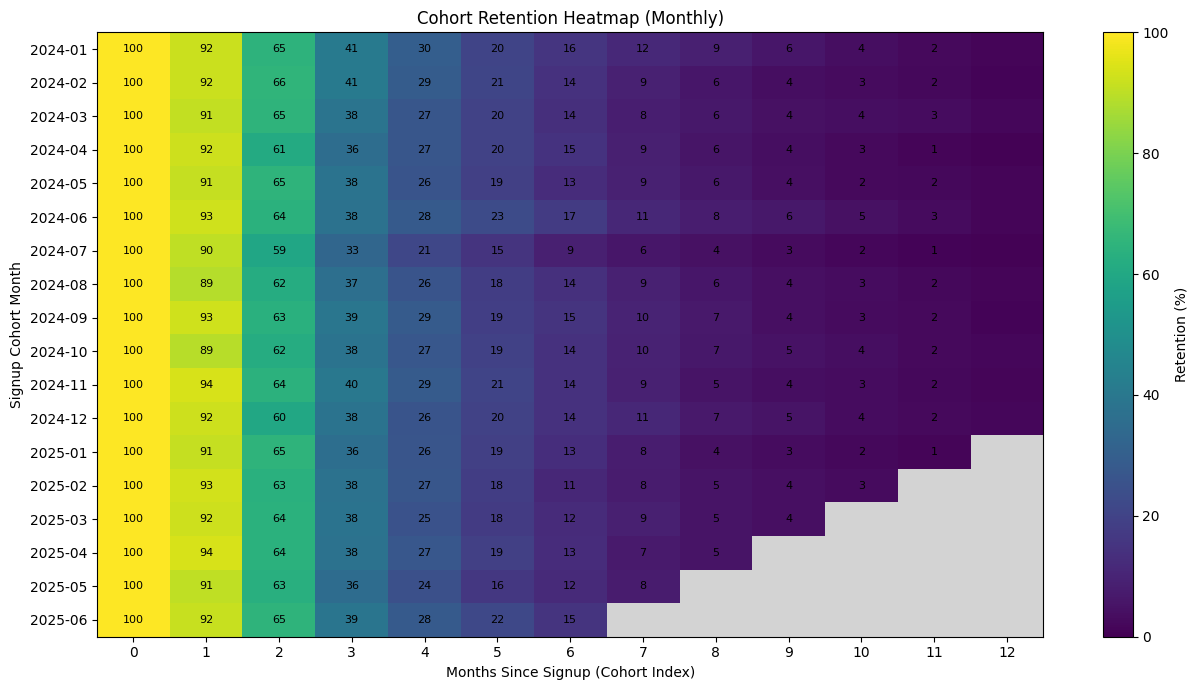

In [570]:
import numpy as np
import matplotlib.pyplot as plt

# --- choose display window ---
max_month = 12                    # show cohort_index 0..12
last_n_cohorts = 18               # show most recent 18 signup cohorts

ret = (retention_table * 100).round(1)

# Keep only desired columns/rows
ret = ret.loc[:, ret.columns <= max_month]
ret = ret.tail(last_n_cohorts)

# Mask missing cells (these are cohorts that haven't reached that month yet)
masked = np.ma.masked_invalid(ret.values)

plt.figure(figsize=(13, 7))
cmap = plt.cm.viridis.copy()
cmap.set_bad(color="lightgray")   # color for missing cells

img = plt.imshow(masked, aspect="auto", cmap=cmap, vmin=0, vmax=100)
plt.colorbar(img, label="Retention (%)")

plt.title("Cohort Retention Heatmap (Monthly)")
plt.xlabel("Months Since Signup (Cohort Index)")
plt.ylabel("Signup Cohort Month")

# Ticks
plt.xticks(ticks=np.arange(ret.shape[1]), labels=ret.columns.tolist())
plt.yticks(
    ticks=np.arange(ret.shape[0]),
    labels=[d.strftime("%Y-%m") for d in ret.index]
)

# Annotate only first 0..6 months (keeps it readable)
annot_upto = min(12, ret.shape[1])
for i in range(ret.shape[0]):
    for j in range(annot_upto):
        val = ret.iat[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{val:.0f}", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/cohort-retention-analysis/figures/cohort_heatmap.png")
plt.show()

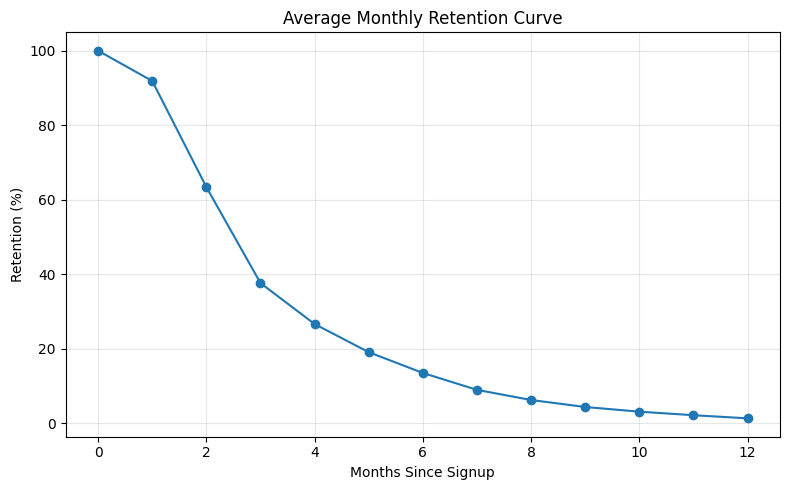

In [569]:
import matplotlib.pyplot as plt

# Compute average retention across cohorts
avg_retention = retention_table.mean()

# Limit to first 12 months
avg_retention = avg_retention.loc[avg_retention.index <= 12] * 100

plt.figure(figsize=(8, 5))
plt.plot(avg_retention.index, avg_retention.values, marker="o")

plt.title("Average Monthly Retention Curve")
plt.xlabel("Months Since Signup")
plt.ylabel("Retention (%)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/cohort-retention-analysis/figures/retention_curve.png")
plt.show()

In [548]:
# Merge acquisition channel onto events
events = events.merge(
    users[["user_id", "acquisition_channel"]],
    on="user_id",
    how="left"
)

events[["user_id", "acquisition_channel"]].head()

,user_id,acquisition_channel
0,U_1,paid_social
1,U_1,paid_social
2,U_1,paid_social
3,U_1,paid_social
4,U_1,paid_social


In [549]:
# ---------------------------------
# STEP 6: Retention by Acquisition Channel
# ---------------------------------

# Count unique active users by channel + cohort_index
channel_data = (
    events.groupby(["acquisition_channel", "cohort_index"])["user_id"]
    .nunique()
    .reset_index(name="active_users")
)

# Get total users per channel (Month 0 baseline)
channel_sizes = (
    users.groupby("acquisition_channel")["user_id"]
    .nunique()
)

# Pivot into matrix
channel_pivot = channel_data.pivot(
    index="acquisition_channel",
    columns="cohort_index",
    values="active_users"
)

# Convert to retention rate
channel_retention = channel_pivot.divide(channel_sizes, axis=0)

channel_retention.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
acquisition_channel,,,,,,,,,,,,,
affiliate,1.0,0.895833,0.596726,0.354167,0.243056,0.179067,0.130952,0.078869,0.053075,0.032242,0.021825,0.014385,0.006448
organic,1.0,0.926054,0.663544,0.406211,0.290116,0.211733,0.150850,0.092926,0.059650,0.036973,0.025635,0.017994,0.011092
paid_search,1.0,0.920799,0.626502,0.367744,0.258758,0.182434,0.130987,0.087155,0.058216,0.040278,0.027077,0.019123,0.011508
paid_social,1.0,0.898372,0.590909,0.326320,0.228662,0.160778,0.109170,0.070663,0.047241,0.032156,0.021636,0.013497,0.007940
referral,1.0,0.954027,0.706711,0.450336,0.325839,0.234899,0.165101,0.104698,0.072483,0.051342,0.034564,0.020470,0.010738


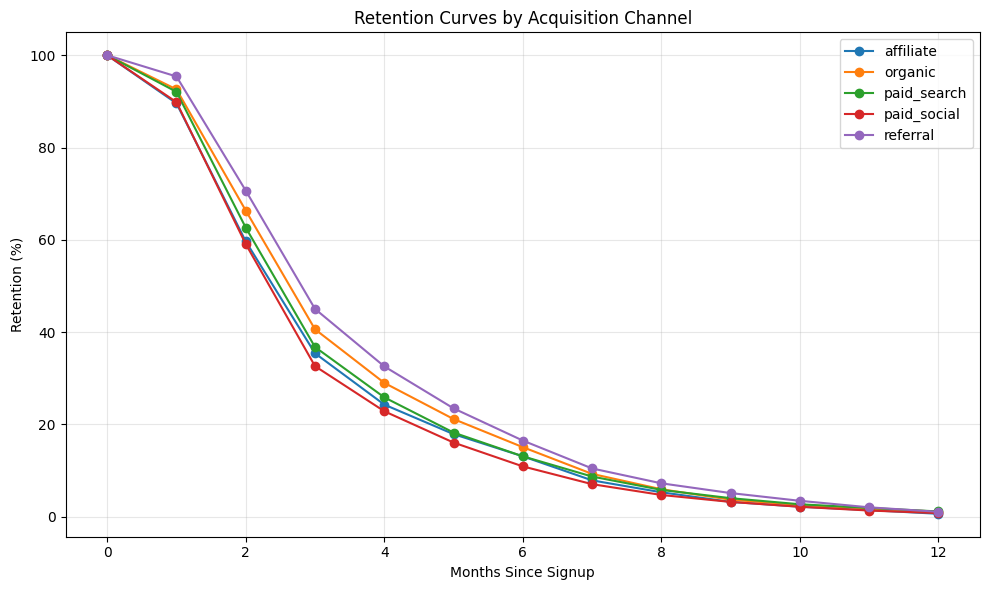

In [550]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for channel in channel_retention.index:
    plt.plot(
        channel_retention.columns,
        channel_retention.loc[channel] * 100,
        marker='o',
        label=channel
    )

plt.title("Retention Curves by Acquisition Channel")
plt.xlabel("Months Since Signup")
plt.ylabel("Retention (%)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Referral-acquired users demonstrate significantly higher 3-month retention compared to paid social, suggesting stronger intent and higher lifetime value potential. Paid social may require improved targeting or onboarding optimization to improve quality.

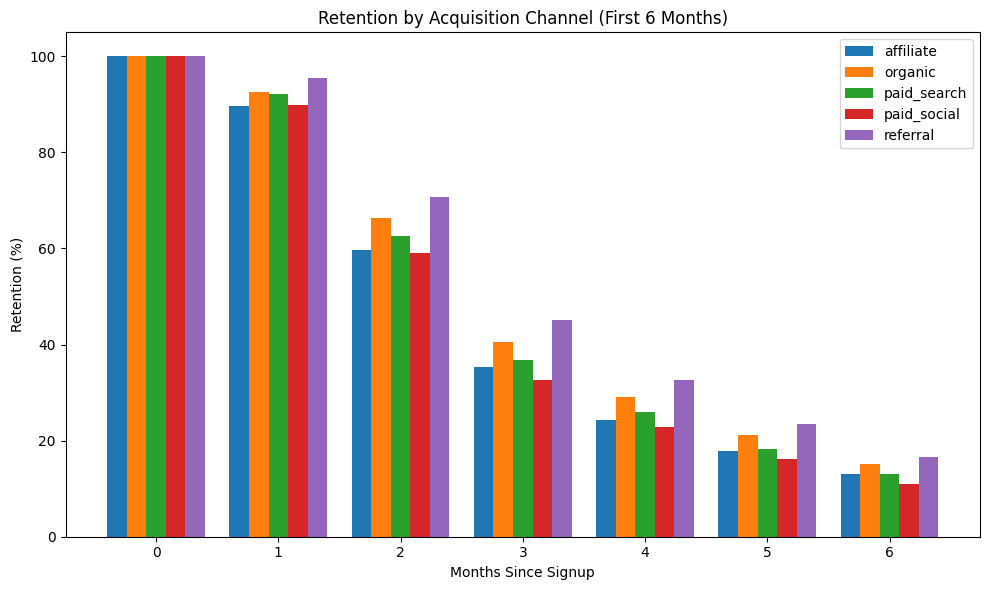

In [551]:
import numpy as np
import matplotlib.pyplot as plt

# Limit to first 6 months for readability
max_month = 6
retention_subset = channel_retention.loc[:, :max_month] * 100

channels = retention_subset.index
months = retention_subset.columns

x = np.arange(len(months))
width = 0.8 / len(channels)  # dynamic bar width

plt.figure(figsize=(10, 6))

for i, channel in enumerate(channels):
    plt.bar(
        x + i * width,
        retention_subset.loc[channel],
        width=width,
        label=channel
    )

plt.xticks(x + width * (len(channels) - 1) / 2, months)
plt.xlabel("Months Since Signup")
plt.ylabel("Retention (%)")
plt.title("Retention by Acquisition Channel (First 6 Months)")
plt.legend()
plt.tight_layout()
plt.show()

In [552]:
# ---------------------------------
# STEP 8A: Create funding segment
# ---------------------------------

# Identify deposit users
deposit_users = events[events["event_name"] == "deposit"]["user_id"].unique()

# Identify direct deposit users
dd_users = events[events["event_name"] == "direct_deposit_received"]["user_id"].unique()

def funding_segment(user_id):
    if user_id in dd_users:
        return "direct_deposit"
    elif user_id in deposit_users:
        return "deposit_only"
    else:
        return "no_funding"

users["funding_segment"] = users["user_id"].apply(funding_segment)

users["funding_segment"].value_counts()

,count
funding_segment,
deposit_only,9252
no_funding,9185
direct_deposit,1563


In [553]:
# ---------------------------------
# STEP 8B: Retention by Funding Segment
# ---------------------------------

# Merge funding segment onto events
events = events.merge(
    users[["user_id", "funding_segment"]],
    on="user_id",
    how="left"
)

# Count active users by funding segment + cohort_index
funding_data = (
    events.groupby(["funding_segment", "cohort_index"])["user_id"]
    .nunique()
    .reset_index(name="active_users")
)

# Get total users per funding segment
funding_sizes = (
    users.groupby("funding_segment")["user_id"]
    .nunique()
)

# Pivot
funding_pivot = funding_data.pivot(
    index="funding_segment",
    columns="cohort_index",
    values="active_users"
)

# Convert to retention rate
funding_retention = funding_pivot.divide(funding_sizes, axis=0)

funding_retention.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
funding_segment,,,,,,,,,,,,,
deposit_only,1.0,0.987138,0.782750,0.585927,0.437527,0.314959,0.214656,0.129053,0.081604,0.052529,0.033939,0.020428,0.010160
direct_deposit,1.0,0.998720,0.923864,0.800384,0.690979,0.568138,0.451695,0.335893,0.250800,0.180422,0.131798,0.099168,0.066539
no_funding,1.0,0.836037,0.434839,0.092433,0.020795,0.000653,NaN,NaN,NaN,NaN,NaN,NaN,NaN


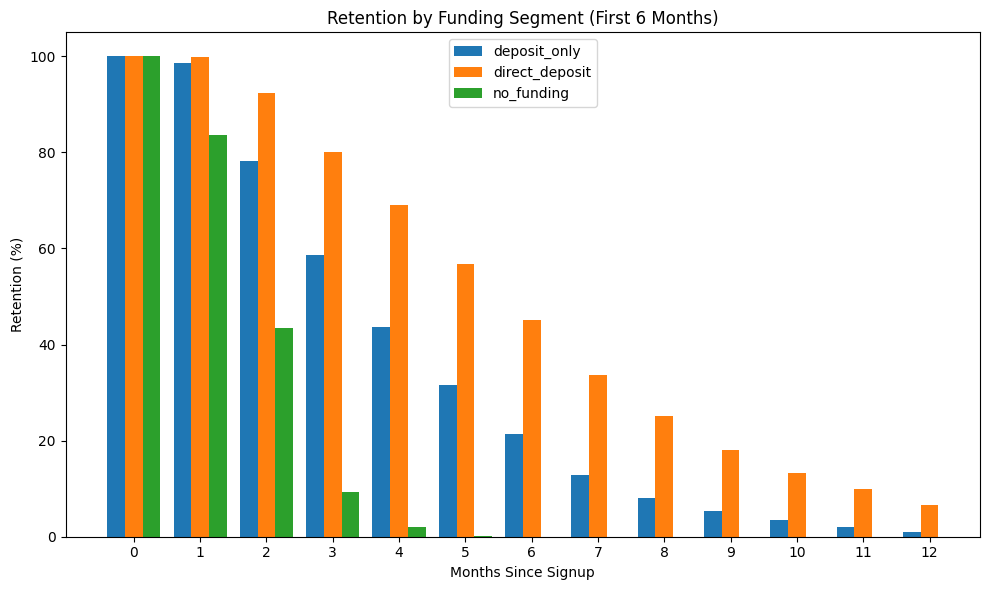

In [568]:
import numpy as np
import matplotlib.pyplot as plt

# Limit to first 6 months
max_month = 12
funding_subset = funding_retention.loc[:, :max_month] * 100

segments = funding_subset.index
months = funding_subset.columns

x = np.arange(len(months))
width = 0.8 / len(segments)

plt.figure(figsize=(10, 6))

for i, segment in enumerate(segments):
    plt.bar(
        x + i * width,
        funding_subset.loc[segment],
        width=width,
        label=segment
    )

plt.xticks(x + width * (len(segments) - 1) / 2, months)
plt.xlabel("Months Since Signup")
plt.ylabel("Retention (%)")
plt.title("Retention by Funding Segment (First 6 Months)")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/cohort-retention-analysis/figures/funding_retention.png")
plt.show()

Users who receive direct deposit show 96+ percentage point lift in 3-month retention compared to unfunded users, indicating that payroll integration is the strongest early lifecycle retention lever.

In [555]:
# ---------------------------------
# STEP 8D: 3-Month Retention Comparison
# ---------------------------------

month = 3

retention_3m = (funding_retention[month] * 100).round(1)

print("3-Month Retention by Funding Segment:")
print(retention_3m)

# Calculate lift vs no_funding
baseline = retention_3m["no_funding"]

lift = (retention_3m - baseline).round(1)

print("\nLift vs No Funding:")
print(lift)

3-Month Retention by Funding Segment:
funding_segment
deposit_only      58.6
direct_deposit    80.0
no_funding         9.2
Name: 3, dtype: float64

Lift vs No Funding:
funding_segment
deposit_only      49.4
direct_deposit    70.8
no_funding         0.0
Name: 3, dtype: float64


Cohort size trend

Are cohorts getting bigger?

Are there seasonal spikes?

Is growth stable?

In [556]:
cohort_sizes = (
    users.groupby("cohort_month")["user_id"]
    .nunique()
    .sort_index()
)

cohort_sizes.head()

,user_id
cohort_month,
2023-05-01,805
2023-06-01,721
2023-07-01,805
2023-08-01,809
2023-09-01,722


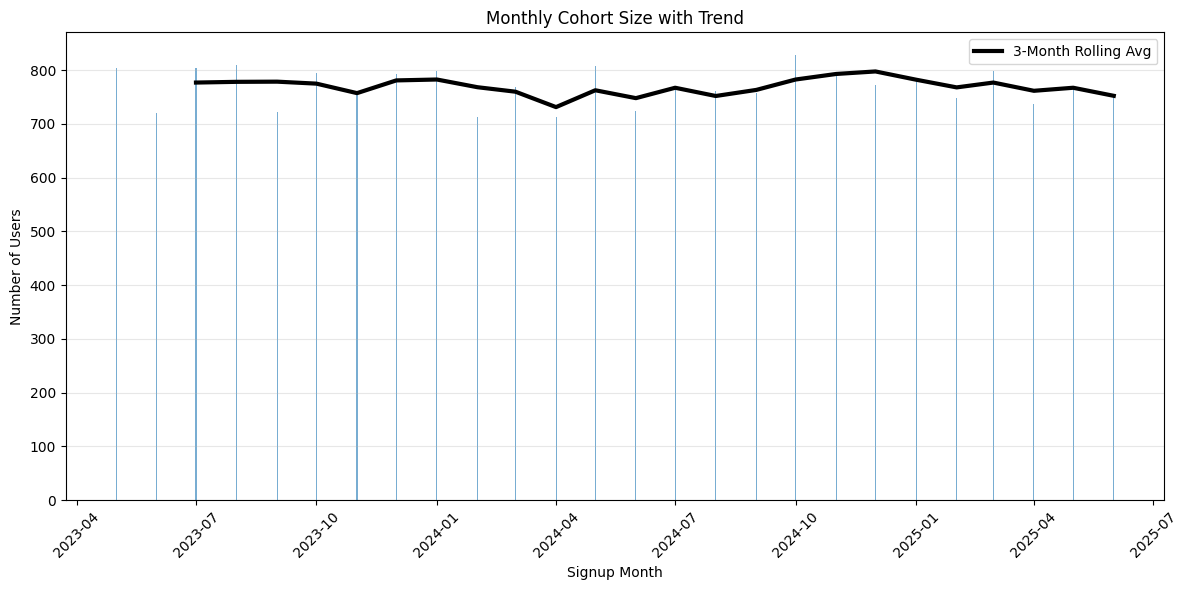

In [557]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime index
cohort_sizes.index = pd.to_datetime(cohort_sizes.index)

# Rolling average
rolling_avg = cohort_sizes.rolling(window=3).mean()

plt.figure(figsize=(12, 6))

# Bars
plt.bar(
    cohort_sizes.index,
    cohort_sizes.values,
    alpha=0.6
)

# Trend line
plt.plot(
    rolling_avg.index,
    rolling_avg.values,
    color="black",
    linewidth=3,
    label="3-Month Rolling Avg"
)

plt.title("Monthly Cohort Size with Trend")
plt.xlabel("Signup Month")
plt.ylabel("Number of Users")

plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

3 month retention across cohorts

Are newer users retaining better?

Is product improving?

Is acquisition quality changing?



In [558]:


month = 3

month3_retention = (retention_table[month] * 100).round(1)

month3_retention.head()

,3
cohort_month,
2023-05-01,37.6
2023-06-01,36.2
2023-07-01,37.9
2023-08-01,36.0
2023-09-01,37.5


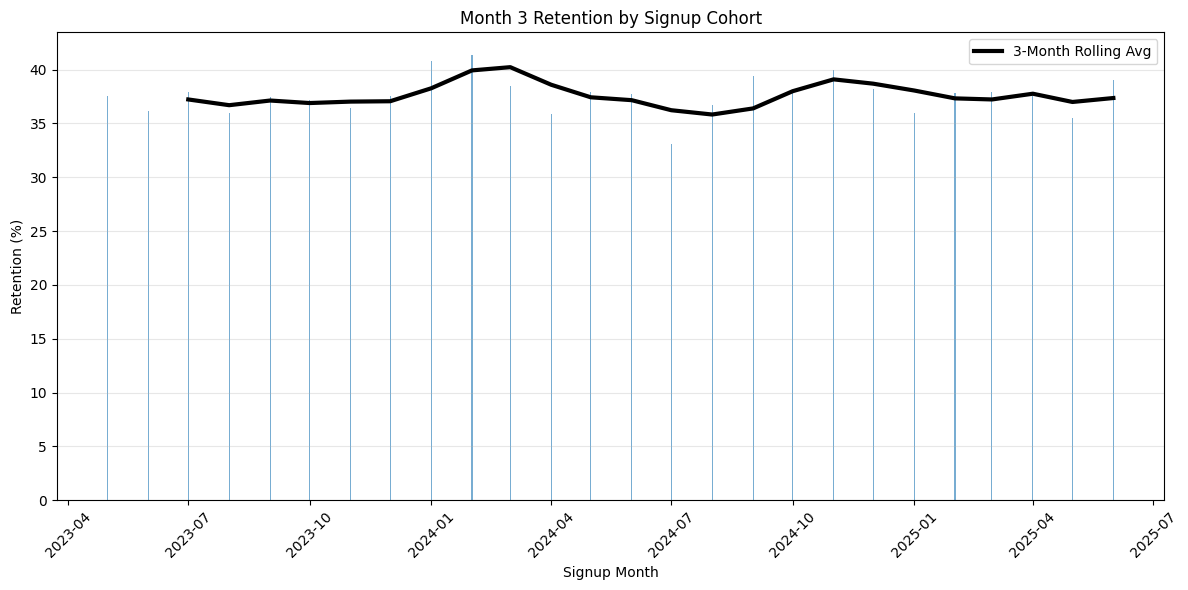

In [559]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime index
month3_retention.index = pd.to_datetime(month3_retention.index)

# Rolling average for smoothing
rolling_avg = month3_retention.rolling(window=3).mean()

plt.figure(figsize=(12, 6))

# Bars (actual values)
plt.bar(
    month3_retention.index,
    month3_retention.values,
    alpha=0.6
)

# Trend line
plt.plot(
    rolling_avg.index,
    rolling_avg.values,
    color="black",
    linewidth=3,
    label="3-Month Rolling Avg"
)

plt.title("Month 3 Retention by Signup Cohort")
plt.xlabel("Signup Month")
plt.ylabel("Retention (%)")

plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

#Time to activation

Days to first funding.

Do users fund immediately?

Does activation mostly happen in first 7 days?

Is there a long tail?

Is your 30-day window realistic?

In [560]:

# First funding timestamp per user
first_funding = (
    events[events["event_name"].isin(["deposit", "direct_deposit_received"])]
    .groupby("user_id")["event_ts"]
    .min()
)

# Merge onto users
users = users.merge(
    first_funding.rename("first_funding_ts"),
    on="user_id",
    how="left"
)

# Calculate days to activation
users["days_to_funding"] = (
    users["first_funding_ts"] - users["signup_date"]
).dt.days

users[["user_id", "days_to_funding"]].head()

,user_id,days_to_funding
0,U_1,NaN
1,U_2,7.0
2,U_3,19.0
3,U_4,22.0
4,U_5,24.0


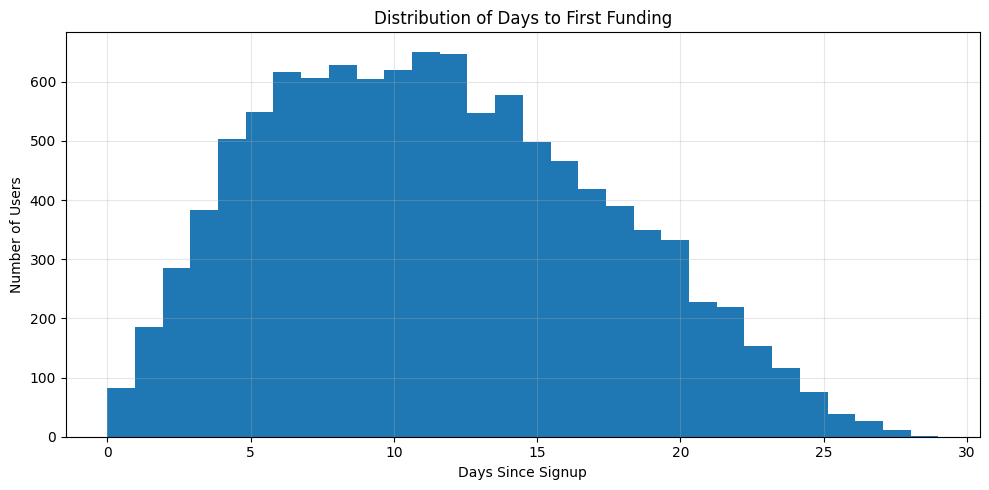

Median days to funding: 11
Mean days to funding: 11.4


In [561]:
import matplotlib.pyplot as plt
import numpy as np

# Remove users who never funded
funded_users = users["days_to_funding"].dropna()

plt.figure(figsize=(10, 5))

plt.hist(
    funded_users,
    bins=30
)

plt.title("Distribution of Days to First Funding")
plt.xlabel("Days Since Signup")
plt.ylabel("Number of Users")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Median days to funding:", int(np.median(funded_users)))
print("Mean days to funding:", round(np.mean(funded_users), 1))

Activation Speed vs Retention

In [562]:
# ---------------------------------
# STEP 4A: Activation Speed Buckets
# ---------------------------------

def activation_bucket(days):
    if pd.isna(days):
        return "no_funding"
    elif days <= 7:
        return "0-7 days"
    elif days <= 14:
        return "8-14 days"
    else:
        return "15-30 days"

users["activation_bucket"] = users["days_to_funding"].apply(activation_bucket)

users["activation_bucket"].value_counts()

,count
activation_bucket,
no_funding,9185
8-14 days,4277
15-30 days,3326
0-7 days,3212


In [563]:
# ---------------------------------
# STEP 4B: 3-Month Retention by Activation Speed
# ---------------------------------

bucket_order = ["0-7 days", "8-14 days", "15-30 days", "no_funding"]
users["activation_bucket"] = pd.Categorical(users["activation_bucket"], categories=bucket_order, ordered=True)

# Month 3 window = days 60–89 since signup
users["signup_date"] = pd.to_datetime(users["signup_date"])
events["event_ts"] = pd.to_datetime(events["event_ts"])

events_m = events.merge(users[["user_id", "signup_date"]], on="user_id", how="left")
events_m["days_since_signup"] = (events_m["event_ts"] - events_m["signup_date"]).dt.days

active_month3 = events_m.loc[
    (events_m["days_since_signup"] >= 60) & (events_m["days_since_signup"] < 90),
    "user_id"
].unique()

users["active_month3"] = users["user_id"].isin(active_month3)

activation_retention = (
    users.groupby("activation_bucket", observed=True)["active_month3"]
    .mean().mul(100).round(0).fillna(0).astype(int).astype(str) + "%"
)

activation_retention

,active_month3
activation_bucket,
0-7 days,77%
8-14 days,71%
15-30 days,65%
no_funding,12%


In [564]:
activation_retention_numeric = (
    activation_retention.astype(str)
    .str.replace("%", "", regex=False)
    .str.strip()
)

activation_retention_numeric = pd.to_numeric(activation_retention_numeric, errors="coerce")

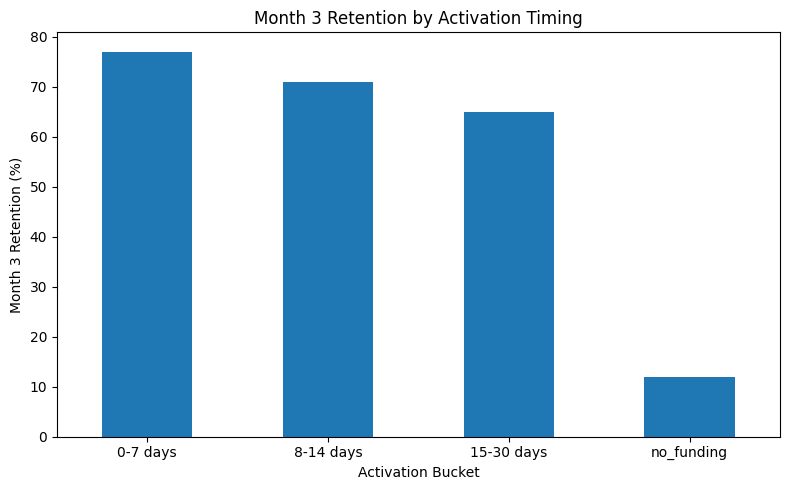

In [567]:
import os
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(8,5))
activation_retention_numeric.plot(kind="bar")

plt.title("Month 3 Retention by Activation Timing")
plt.xlabel("Activation Bucket")
plt.ylabel("Month 3 Retention (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/cohort-retention-analysis/figures/activation_bucket.png")
plt.show()